In [1]:
import numpy as np
import pandas as pd
from interactions_data import ExplicitDataset
from interactions_model import EmbeddingNet, find_lr, fit_model
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
import CLR as CLR
import OneCycle as OneCycle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
path = '../data/jester/'
train = ExplicitDataset(csv_file=path+'train_long.csv')
test = ExplicitDataset(csv_file=path+'test_long.csv')

In [4]:
print("Training samples: ", 
      len(train),
      "\nTesting samples: ",
      len(test))

Training samples:  1296635 
Testing samples:  432212


In [5]:
train.df.head()

,user_id,joke_id,rating
0,34378,106,1.37500
1,28664,127,9.93750
2,5779,3,1.21875
3,11410,3,9.21875
4,7038,116,8.43750


In [6]:
test.df.head()

,user_id,joke_id,rating
0,30173,5,-9.43750
1,22868,133,-3.00000
2,8434,71,-4.56250
3,30260,2,2.56250
4,29438,8,1.84375


In [8]:
n_users = train.df.user_id.nunique()
n_items = train.df.joke_id.nunique()
max_score = max(train.df.rating)
min_score = min(train.df.rating)
epoch = 10
bs = 256

In [9]:
n_items

140

### Check that all users and jokes appear in both train and test

In [22]:
print("Jokes in train set:", train.df.joke_id.nunique())
print("Min:", min(train.df.joke_id.unique()), 
      "Max:", max(train.df.joke_id.unique()), "\n")
print("Jokes in test set:", test.df.joke_id.nunique())
print("Min:", min(test.df.joke_id.unique()), 
      "Max:", max(test.df.joke_id.unique()))

Jokes in train set: 140
Min: 0 Max: 139 

Jokes in test set: 140
Min: 0 Max: 139


In [23]:
print("Users in train set:", train.df.user_id.nunique())
print("Min:", min(train.df.user_id.unique()), 
      "Max:", max(train.df.user_id.unique()), "\n")
print("Users in test set:", test.df.user_id.nunique())
print("Min:", min(test.df.user_id.unique()), 
      "Max:", max(test.df.user_id.unique()))

Users in train set: 50692
Min: 0 Max: 50691 

Users in test set: 50692
Min: 0 Max: 50691


In [24]:
train_loader = DataLoader(dataset=train,
                          batch_size=bs,
                          shuffle=False)

test_loader = DataLoader(dataset=test,
                         batch_size=bs,
                         shuffle=False)

In [25]:
# create the model
model = EmbeddingNet(10, n_users, n_items, min_score, max_score).cuda()

# show its parameters
model

EmbeddingNet(
  (u): Embedding(50692, 10)
  (i): Embedding(140, 10)
  (lin1): Linear(in_features=20, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.15)
)

## Learning rate finder

In [26]:
# define the optimizer and loss criterion
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)
criterion=nn.MSELoss()

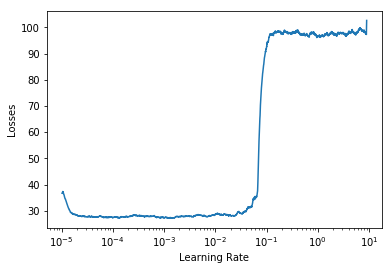

In [27]:
find_lr(model, train_loader, optimizer, criterion)

In [28]:
# create new model with re-initialized weights
model = EmbeddingNet(10, n_users, n_items, min_score, max_score).cuda()

In [29]:
# set the learning rate
lr = 1e-3

## Cyclic Learning Rates

In [13]:
onecycle = OneCycle.OneCycle(nb=int(len(train_loader)*epoch/bs), 
                             max_lr=1e-2,
                             momentum_vals=(0.95, 0.8))

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.95, weight_decay=1e-4)

## Training

In [31]:
fit_model(epochs=10, 
          model=model, 
          optimizer=optimizer,
          criterion=criterion,
          train=train_loader, 
          test=test_loader)

Epoch: 1/10..  Training Loss: 27.881..  Test Loss: 27.726.. 


Epoch: 2/10..  Training Loss: 27.871..  Test Loss: 27.726.. 


Epoch: 3/10..  Training Loss: 27.871..  Test Loss: 27.726.. 


KeyboardInterrupt: 

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

NameError: name 'train_losses' is not defined

In [53]:
model.eval()

dataiter = iter(test_loader)
users, items, ratings = dataiter.next()

In [54]:
with torch.no_grad():
    output = model(users, items).view(256).cpu().numpy()

ratings = ratings.cpu().numpy()

In [60]:
mse = np.mean((ratings - output)**2)

(array([25., 39., 39., 32., 25., 24., 22., 23., 12., 15.]),
 array([-10.206074 ,  -7.9924283,  -5.778783 ,  -3.5651371,  -1.3514916,
          0.862154 ,   3.0757995,   5.289445 ,   7.503091 ,   9.716736 ,
         11.930382 ], dtype=float32),
 <a list of 10 Patch objects>)

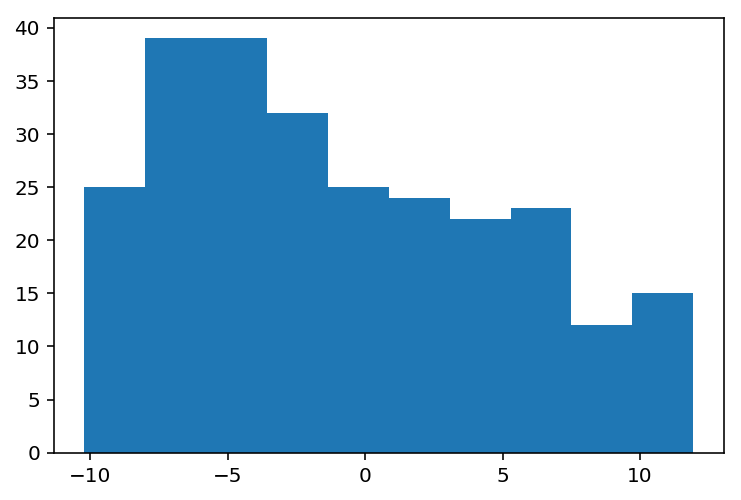

In [63]:
plt.hist(errs)